In [1]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import dill
import dask, dask_ml
import dask.dataframe as dd

from importlib import reload
from scipy import signal, stats
from tqdm.auto import tqdm
from sklearn import neighbors, linear_model, ensemble, decomposition #svm, neural_network
from sklearn import feature_selection, model_selection, metrics, dummy, pipeline, preprocessing, compose
from dask_ml.model_selection import RandomizedSearchCV
from matplotlib import pyplot as plt
from src import main, feature_model
from itertools import product

In [2]:
from dask_jobqueue import SLURMCluster
from distributed import Client, LocalCluster

In [3]:
try:
    cluster.close()
    client.close()
except NameError:
    pass
finally:
    cluster = SLURMCluster(queue='short', 
                           cores=4, 
                           memory='18gB', 
                           walltime='4:00:00', 
                           death_timeout=60, 
                          )
#                            job_extra=['--exclude=/home/hy180/notibnodes'])
    client = Client(cluster)
    cluster.adapt(minimum=0, maximum=200, wait_count=5)

# Load data

In [81]:
dataset = 'cis-fftfeatures'
features_df = pd.read_csv(f'/home/hy180/projects/beat_pd/extracted_features/ensem/{dataset}.csv') #.set_index(['samp_id', 'id'])

label_cols = ['on_off', 'dyskinesia', 'tremor', 'subject_id']
labels = pd.concat([
    pd.read_csv('/home/hy180/projects/beat_pd/data/cis-pd/data_labels/CIS-PD_Training_Data_IDs_Labels.csv'),
    pd.read_csv('/home/hy180/projects/beat_pd/data/real-pd/data_labels/REAL-PD_Training_Data_IDs_Labels.csv'),
], axis=0).astype({'subject_id': str})

df = features_df.dropna().merge(labels, right_on='measurement_id', left_on='samp_id')
print('%d rows dropped due to nans in features' % (features_df.shape[0] - df.shape[0]))

In [129]:
label = 'tremor'

id_cols = ['measurement_id', 'samp_id', 'ord']
labeled_samps = df.dropna(subset=[label])

y = df.loc[labeled_samps.index, label].astype('int')
X = labeled_samps.drop(columns=[*label_cols, *id_cols])

# Model

## Model spec

In [105]:
scaler = preprocessing.RobustScaler(quantile_range=(1, 99))
scaler_pg = {'scaler__quantile_range': [(.1, 99.9), (.5, 99.5), (1, 99), (5, 95), (10, 90)],}
# scaler = preprocessing.MinMaxScaler()

# Keep features w/ variance in top 95%ile 
var = lambda X, y: np.var(X, axis=0)
f_select = feature_selection.SelectPercentile(var, percentile=95)
# f_select_pg = {'f_select__percentile': [95, 80, 50, 25, 10],}
f_select_pg = {'f_select__percentile': stats.uniform(0, 100)}
# f_select = feature_selection.SelectKBest(feature_selection.mutual_info_regression, k=30)

# model = linear_model.Ridge()
# model_pg = {'model__regressor__alpha': [0.1, 0.5, 1, 2, 5],}
# model = svm.SVR()
# model_pg = {'model__regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'model__regressor__C': stats.chi2(df=2)}
# model = linear_model.ElasticNet()
# model_pg = {'model__regressor__l1_ratio': stats.uniform(0, 1), 'model__regressor__alpha': stats.chi2(df=2), }
# model_pg = {'model__regressor__l1_ratio': [0.01, 0.1, 0.5, 0.8, 0.99], 'model__regressor__alpha': [0.1, 0.5, 1, 2, 5],}
# model = mord.OrdinalRidge()
# model_pg = {'model__regressor__alpha': stats.chi2(df=2), }
model = ensemble.RandomForestRegressor()
model_pg = {'model__regressor__n_estimators': stats.randint(50, 100), 'model__regressor__max_depth': stats.randint(10, 25), 'model__regressor__max_features': [.25, 'auto']}
# model = neural_network.MLPRegressor(learning_rate='adaptive')
# model_pg = {'model__regressor__hidden_layer_sizes': [(100), (50, 50)]}

clip_out = preprocessing.FunctionTransformer(np.clip, kw_args={'a_min': 0, 'a_max': 4})
clipped_model = compose.TransformedTargetRegressor(regressor=model, inverse_func=clip_out.transform)

pipe = pipeline.Pipeline([
    ('scaler', scaler), 
    ('f_select', f_select), 
    ('model', clipped_model),
], verbose=1)

param_grid = {
    **scaler_pg,
    **f_select_pg,
    **model_pg,
}

metric = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)

cv = model_selection.StratifiedKFold(shuffle=True)

## Model eval

In [106]:
for label in ['dyskinesia', 'on_off', 'tremor']:
    print(f'working on {label}')

    id_cols = ['measurement_id', 'samp_id']
    labeled_samps = df.dropna(subset=[label])

    y = df.loc[labeled_samps.index, label].astype('int')
    X = labeled_samps.drop(columns=[*label_cols, *id_cols])

    search = RandomizedSearchCV(pipe, param_grid, n_iter=20, scoring=metric, cv=cv, refit=False, scheduler=client)
    cv_fit = search.fit(X, y)
    cv_results = pd.DataFrame(cv_fit.cv_results_)

    resultset_name = f'{dataset}_{type(model).__name__}_{label}'
    cv_results.to_csv(f'performance/cv_paramsweeps/{resultset_name}.csv')
    win_params = cv_results.loc[cv_results.rank_test_score == 1, 'params'].values[0]
    winner = pipe.set_params(**win_params)
    with open(f'models/paramsweep_winners/{resultset_name}.model', 'wb') as f:
        dill.dump(winner, f)
    print(f'done with {label}')
    

    try:
        cluster.close()
        client.close()
    except NameError:
        pass
    finally:
        cluster = SLURMCluster(queue='short', 
                               cores=4, 
                               memory='18gB', 
                               walltime='4:00:00', 
                               death_timeout=60, 
                              )
        client = Client(cluster)
        cluster.adapt(minimum=0, maximum=200, wait_count=5)

working on dyskinesia
done with dyskinesia
working on on_off
done with on_off
working on tremor
done with tremor


In [140]:
cv_results.sort_values('rank_test_score')

,Unnamed: 0,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,param_f_select__percentile,param_model__regressor__max_depth,param_model__regressor__max_features,param_model__regressor__n_estimators,param_scaler__quantile_range
15,15,"{'f_select__percentile': 98.3611884393561, 'mo...",1702.550330,97.710884,2.484277,0.113361,-0.755847,-0.758377,-0.760052,-0.757093,-0.757036,-0.757681,0.001431,1,98.361188,22,auto,99,"(5, 95)"
14,14,"{'f_select__percentile': 81.65338027432493, 'm...",1100.612363,91.693866,1.612955,0.132383,-0.756162,-0.759688,-0.760165,-0.759685,-0.758532,-0.758846,0.001446,2,81.653380,17,auto,87,"(5, 95)"
2,2,"{'f_select__percentile': 99.88620365911981, 'm...",1071.344809,48.122568,1.582189,0.040434,-0.756140,-0.761133,-0.760807,-0.758867,-0.759245,-0.759238,0.001777,3,99.886204,19,auto,65,"(5, 95)"
17,17,"{'f_select__percentile': 97.71313701250916, 'm...",230.332544,16.682757,1.143255,0.042678,-0.758153,-0.761192,-0.761522,-0.759947,-0.760301,-0.760223,0.001183,4,97.713137,14,0.25,67,"(5, 95)"
0,0,"{'f_select__percentile': 91.1415914156503, 'mo...",1293.373676,66.778473,2.039745,0.083376,-0.758545,-0.761923,-0.762547,-0.760939,-0.760214,-0.760833,0.001397,5,91.141591,22,auto,78,"(10, 90)"
8,8,"{'f_select__percentile': 89.47676158166064, 'm...",289.029553,24.457210,1.404081,0.062530,-0.759227,-0.762630,-0.762545,-0.762615,-0.761041,-0.761612,0.001336,6,89.476762,13,0.25,89,"(1, 99)"
19,19,"{'f_select__percentile': 53.8849240013158, 'mo...",142.121830,4.768276,1.282561,0.157856,-0.763678,-0.765782,-0.765985,-0.765736,-0.764105,-0.765057,0.000965,7,53.884924,15,0.25,78,"(0.5, 99.5)"
7,7,"{'f_select__percentile': 62.078276068007064, '...",472.301534,15.247355,0.751615,0.038152,-0.762629,-0.767258,-0.765798,-0.766571,-0.765691,-0.765589,0.001585,8,62.078276,11,auto,65,"(10, 90)"
1,1,"{'f_select__percentile': 51.91469042723275, 'm...",174.294263,9.645774,1.980740,0.330170,-0.765389,-0.767062,-0.766308,-0.766112,-0.765096,-0.765993,0.000696,9,51.914690,21,0.25,77,"(10, 90)"
6,6,"{'f_select__percentile': 54.78192256976766, 'm...",138.435357,8.929972,1.464540,0.178411,-0.763867,-0.767638,-0.766243,-0.767215,-0.765102,-0.766013,0.001384,10,54.781923,19,0.25,58,"(0.1, 99.9)"


### Dask debugging 

In [ ]:
# Pull up erring key
err = client.futures["('score-b0e3729a01d6f20aec7498c297e3c3b1', 24, 2)"]
key, err = client.futures.popitem()
# keys, states = [*zip(*[*client.futures.items()])]

In [ ]:
import traceback as tb
tb.print_tb(err.traceback)
print(err.exception)

## Single train-test split for evaluation

In [120]:
import ast

cv_results = pd.read_csv(f'performance/cv_paramsweeps/{dataset}_{type(model).__name__}_{label}.csv')
win_params = ast.literal_eval(cv_results.loc[cv_results.rank_test_score == 1, 'params'].values[0])
winner = pipe.set_params(**win_params)

In [138]:
X_c = X.reset_index(drop=True)
y_c = y.reset_index(drop=True)
samp_map = labeled_samps.loc[:, 'samp_id'].reset_index(drop=True)

x_train, x_test, y_train, y_test = model_selection.train_test_split(X_c, y_c, test_size=.25, stratify=y_c)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.1s
[Pipeline] .......... (step 2 of 3) Processing f_select, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=  28.1s


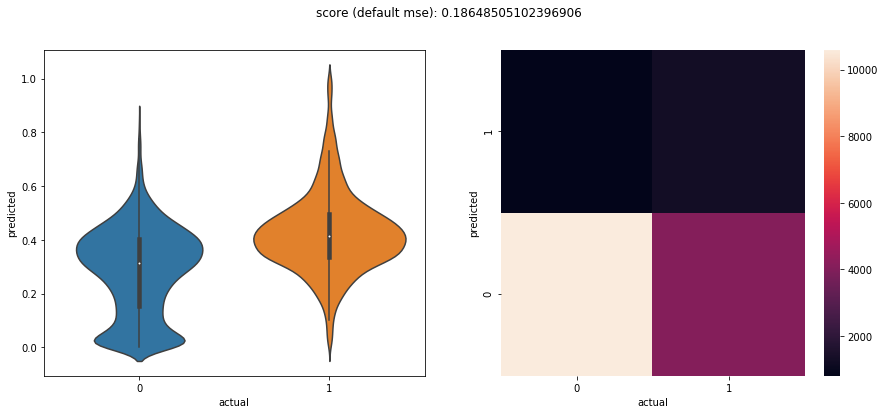

In [98]:
with joblib.parallel_backend('loky'):
    winner.fit(x_train, y_train)
    pred = winner.predict(x_test)

main.plot_performance(y_test, pred)

In [94]:
pd.Series(data=winner.named_steps['model'].regressor_.feature_importances_,
          index=X.columns[winner.named_steps['f_select'].get_support()]).sort_values().iloc[-20:]

3.9    0.020125
1.9    0.020288
0.1    0.020823
1.7    0.020954
1.2    0.021244
0.9    0.021320
4.7    0.021368
1.1    0.021971
4.4    0.021996
0.8    0.022225
4.9    0.022285
0.5    0.022628
2.0    0.023208
0.4    0.023258
3.3    0.023837
4.8    0.023940
3.7    0.024412
1.6    0.024991
0.6    0.026086
ord    0.028248
dtype: float64

###  Combine window predictions using mean

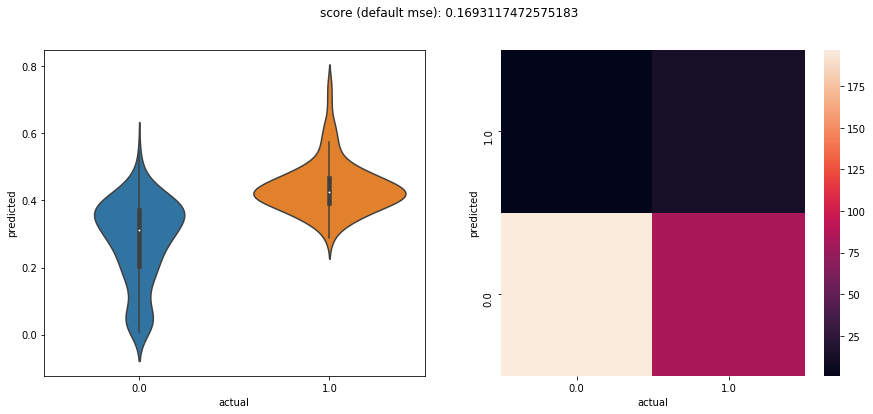

In [60]:
# Ensemble prediction by taking mean of window predictions 
ensem_pred = pd.DataFrame({'samp_id': samp_map[y_test.index], 'pred': pred}).groupby('samp_id').mean()
result = ensem_pred.join(labels.loc[labels.measurement_id.isin(ensem_pred.index)].set_index('measurement_id')[label])
main.plot_performance(result[label], result.pred)

#### Look at range of predictions on single observation

Text(0.5, 1.0, '1f8d2c61-70d2-4292-a75a-1e5164460e06 actual: 1.0')

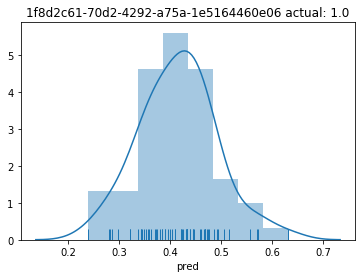

In [80]:
# Look at single 
s = samp_map.sample().values[0]
d = pd.DataFrame({'samp_id': samp_map[y_test.index], 'pred': pred})
ax = sns.distplot(d[d.samp_id == s].pred, rug=True)
ax.set_title(f'{s} actual: {labels[labels.measurement_id == s][label].values[0]}')

In [179]:
samp_map.value_counts()

89acf665-fe65-4251-bb91-1f5dbf7b4c6a    238
9446b6f3-6c09-4366-8b60-ac3d10387880    238
d44b61dc-6440-4b80-adb7-488104fa7cbe    238
fb82d4fa-d118-4d5b-ae61-46bfdfb91247    238
7a5aaf70-b362-4cab-8ad2-10a5edfc4a39    238
                                       ... 
b5098d2c-fdec-485c-a855-bd5cd7ff68ea     31
92a5282f-27d2-4608-9e23-cfe3ac6863df     30
b4b4486b-ecfb-43a9-a09f-0e1f613b161c     29
6e412bc6-0861-48c3-875d-c7b2e5edafc9     21
2559e082-f3c1-4824-808f-a9c3eb4a8fe5      1
Name: samp_id, Length: 274, dtype: int64

In [224]:
np.percentile(d[d.samp_id == s].pred, [25, 75])

array([1.44505415, 2.16233382])

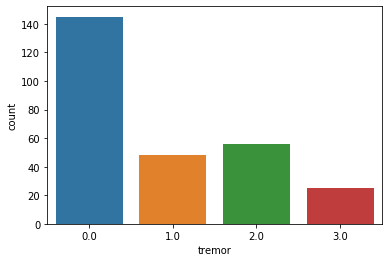

In [171]:
sns.countplot(labels[labels.measurement_id.isin(samp_map.unique())][label])

# Baseline for reference

In [134]:
# label = 'dyskinesia'
labeled_samps = df.dropna(subset=[label])#.drop(columns=[*label_cols, *id_cols])

y = df.loc[labeled_samps.index, label].astype('int')
metric = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)

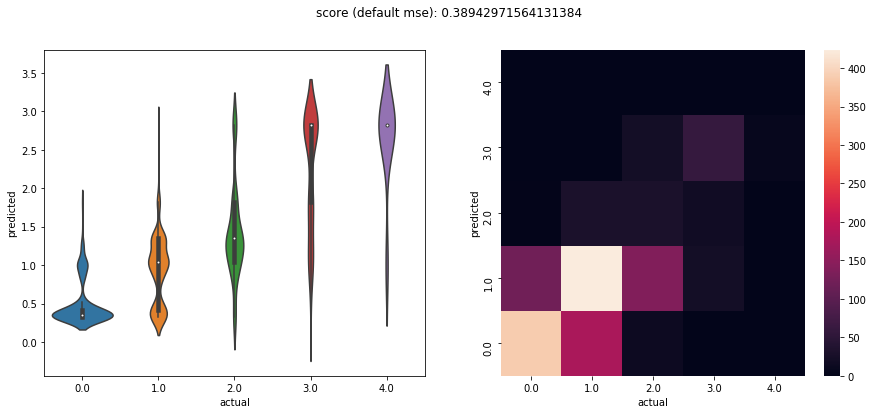

In [139]:
# patient-specific mean predictor
subj_means = labels.groupby('subject_id').mean()
X_subjs = labels[labels.measurement_id.isin(samp_map.unique())][['subject_id']]
actuals = labels[labels.measurement_id.isin(samp_map.unique())][label]
naive_pred = X_subjs.merge(subj_means[[label]], left_on='subject_id', right_index=True).rename(columns={label: 'prediction'})
main.plot_performance(actuals, naive_pred.prediction)

# Predictions on test set

In [ ]:
import ast

cv_results = pd.read_csv(f'performance/cv_paramsweeps/{dataset}_{type(model).__name__}_{label}.csv')
win_params = ast.literal_eval(cv_results.loc[cv_results.rank_test_score == 1, 'params'].values[0])
winner = pipe.set_params(**win_params)

In [ ]:
test_index = pd.read_csv(f'test_predictions/sub_template_{label}.csv', index_col=0).index
test_features_df = pd.concat([
    pd.read_csv('extracted_features/tsfeatures_cis_test.csv', index_col=0), 
    pd.read_csv('extracted_features/tsfeatures_real_test.csv', index_col=0)
]).drop(columns=drop_cols).reindex(test_index)

test_subjs = pd.concat([
    pd.read_csv('data/test_set/cis-pd/cis-pd.CIS-PD_Test_Data_IDs.csv', index_col=0), 
    pd.read_csv('data/test_set/real-pd/real-pd.REAL-PD_Test_Data_IDs.csv', index_col=0)
]).reindex(test_index)

In [ ]:
# Predict patient-specific mean if data not available
nodata_obs = test_subjs.loc[test_features_df[test_features_df.isna().sum(axis=1) > 0].index]
nodata_predictions = nodata_obs.join(subj_means, on='subject_id')[[label]].rename({label: 'prediction'}, axis=1)

In [ ]:
X = test_features_df.dropna(axis='index')

test_predictions = winner.predict(X)
test_predictions_df = pd.concat([
    pd.DataFrame(index=X.index, data={'prediction': test_predictions}),
    nodata_predictions,
], axis=0)

In [ ]:
test_predictions_df.to_csv(f'test_predictions/test_predictions_{label}.csv', index=True)

# Dimensionality Reduction

In [ ]:
features_df['ord'] = features_df.groupby(['samp_id']).cumcount()

In [ ]:
features_df.reset_index(inplace=True)
features_df.set_index(['samp_id', 'id'], inplace=True)

In [ ]:
features_df.drop(columns='index', inplace=True)

In [ ]:
valid_samps = labels[['measurement_id', 'dyskinesia']]

In [ ]:
label = 'dyskinesia'

valid_samps = labels.dropna(subset=['dyskinesia'])['measurement_id']
X = features_df[features_df.index.get_level_values('samp_id').isin(valid_samps) & ~np.isinf(features_df).any(axis=1)]#[features_df.ord < 21].groupby(['samp_id', 'ord']).sum().unstack()

In [ ]:
pca = decomposition.PCA(n_components=4)
fut = client.submit(pca.fit_transform, X)

In [ ]:
proj = client.gather(fut)

In [ ]:
y = labels[['measurement_id', label]].set_index('measurement_id').reindex(X.index.get_level_values('samp_id'))

In [ ]:
fig = plt.figure(figsize=(8, 8))
_ = sns.scatterplot(x=proj[:, 0], y=proj[:, 3], hue=y.dyskinesia, legend='full')

In [ ]:
label = 'subject_id'

X = f_select.fit_transform(scaler.fit_transform(labeled_samps), y=y)
pca = decomposition.FastICA(n_components=2)
proj = pca.fit_transform(X)
fig = plt.figure(figsize=(8, 8))
_ = sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=df.loc[features.index, label], legend='full')

# Archived cells 

In [ ]:
# Local cluster for debugging
try:
    local_cluster.close()
    local_client.close()
except NameError:
    pass
finally:
    local_cluster = LocalCluster(n_workers=4, threads_per_worker=1, dashboard_address='0.0.0.0:8786')
    local_client = Client(local_cluster)
    local_cluster.adapt(minimum=0, maximum=4)